In [1]:
import os
import pandas as pd
import sklearn.metrics
import numpy as np
import plotnine as p9
import optuna
import scipy.stats as stats 
import itertools
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
TRIALS = 250
TOP_N = 1

In [3]:
def load_performance_metrics(dataset, gnn, llm, method, aggregation, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{llm.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N) # .head(3) for R8, BART-large due to exceptions
  
  performance = list()
  #for trial in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{x}')]:
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    for random_state in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{x}')]:
      df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])

In [4]:
def load_performance_metrics_fine_tuned(dataset, llm, display_information = False):
  
  study_name = f'{dataset}-{llm.replace("/", "-")}'
  storage = f'sqlite:///../../baselines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N) # .head(3) for R8, BART-large due to exceptions
  
  performance = list()
  #for trial in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{x}')]:
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    for random_state in [x for x in os.listdir(f'../../outputs/{dataset}-{llm}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{llm}/{trial}/{x}')]:
      df = pd.read_csv(f'../../outputs/{dataset}-{llm}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])

In [5]:
def remove_trials_with_exceptions(df):
  return df.groupby(['trial']).filter(lambda x : len(x) >= 10 * 2).reset_index(drop = True)

In [6]:
def get_best_results(dataset, gnn, llm, method, aggregation, target_metric):
  if gnn is None and method is None and aggregation is None:
    df = load_performance_metrics_fine_tuned(dataset = dataset, llm = llm, display_information = True)
  else:
    df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation, display_information = True)
  df = remove_trials_with_exceptions(df)
  df_aggregated = df.groupby(['trial', 'split']).agg({
    'accuracy' : ['mean', 'std'],
    'f1_score' : ['mean', 'std'],
    'precision' : ['mean', 'std'],
    'recall' : ['mean', 'std'],
  }).reset_index()
  df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
  
  best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']

  best_trial = df_aggregated[df_aggregated['trial'] == best_trial_number]

  print(best_trial_number)
  print('-' * 10, 'Validation', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_std'].values[0] * 100, decimals = 2))
  )

  print('-' * 10, 'Test', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±', 
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_std'].values[0] * 100, decimals = 2))
  )


# RQ 4.5

---------

## SST-2

In [7]:
get_best_results(dataset = 'SST-2', gnn = None, llm = 'google-bert-bert-base-uncased', method = None, aggregation = None, target_metric = 'accuracy')

number                                 198
value                             0.932339
params_balanced_loss                  True
params_batch_size                       13
params_beta_0                     0.824986
params_beta_1                     0.995171
params_early_stopping_patience           4
params_epochs                            6
params_epsilon                         0.0
params_learning_rate               0.00001
params_plateau_divider                   9
params_plateau_patience                  2
params_weight_decay               0.000513
user_attrs_epoch                       6.0
user_attrs_training_loss           0.01948
user_attrs_validation_loss        0.306079
Name: 198, dtype: object
198
---------- Validation ----------
Accuracy: 92.01 ± 0.55
F1-score: 92.00 ± 0.55
Precision: 92.03 ± 0.55
Recall: 92.00 ± 0.56
---------- Test ----------
Accuracy: 91.60 ± 0.43
F1-score: 91.60 ± 0.43
Precision: 91.69 ± 0.41
Recall: 91.61 ± 0.43


In [8]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     221
value                                  0.91055
params_attention_heads                       7
params_attention_pooling_operation         min
params_balanced_loss                      True
params_batch_size                           67
params_beta_0                         0.836906
params_beta_1                         0.988719
params_dropout_rate                   0.469089
params_early_stopping_patience              23
params_embedding_pooling_operation         max
params_epochs                               69
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    238
params_learning_rate                  0.000592
params_number_of_hidden_layers               2
params_plateau_divider                       6
params_plateau_patience                     19
params_threshold                      0.574329
params_weight_decay                   0.000125
user_attrs_ep

In [9]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     255
value                                 0.912844
params_attention_heads                      16
params_attention_pooling_operation         max
params_balanced_loss                      True
params_batch_size                           77
params_beta_0                         0.834165
params_beta_1                         0.981367
params_dropout_rate                   0.454022
params_early_stopping_patience              15
params_embedding_pooling_operation         max
params_epochs                              197
params_epsilon                        0.000002
params_global_pooling                     mean
params_hidden_dimension                    196
params_learning_rate                  0.001156
params_number_of_hidden_layers               3
params_plateau_divider                       5
params_plateau_patience                     11
params_threshold                       0.48984
params_weight_decay                   0.000007
user_attrs_ep

## R8

In [10]:
get_best_results(dataset = 'R8', gnn = None, llm = 'google-bert-bert-base-uncased', method = None, aggregation = None, target_metric = 'f1_score')

number                                 169
value                             0.964472
params_balanced_loss                 False
params_batch_size                       10
params_beta_0                     0.820636
params_beta_1                     0.996903
params_early_stopping_patience           5
params_epochs                            8
params_epsilon                    0.000003
params_learning_rate              0.000028
params_plateau_divider                   7
params_plateau_patience                  4
params_weight_decay               0.000008
user_attrs_epoch                       7.0
user_attrs_training_loss          0.017855
user_attrs_validation_loss        0.085991
Name: 169, dtype: object
169
---------- Validation ----------
Accuracy: 98.08 ± 0.30
F1-score: 94.51 ± 1.08
Precision: 93.92 ± 1.27
Recall: 95.50 ± 1.08
---------- Test ----------
Accuracy: 97.78 ± 0.30
F1-score: 94.37 ± 0.61
Precision: 95.09 ± 0.62
Recall: 93.96 ± 0.72


In [11]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     220
value                                 0.966294
params_attention_heads                       6
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                           92
params_beta_0                         0.895508
params_beta_1                         0.987714
params_dropout_rate                   0.552551
params_early_stopping_patience              20
params_embedding_pooling_operation         min
params_epochs                               64
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    125
params_learning_rate                  0.000316
params_left_stride                          32
params_number_of_hidden_layers               2
params_plateau_divider                       9
params_plateau_patience                     23
params_right_stride                        128
params_thresh

In [12]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     215
value                                 0.957508
params_attention_heads                       8
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                          110
params_beta_0                         0.816872
params_beta_1                         0.996901
params_dropout_rate                   0.348761
params_early_stopping_patience              20
params_embedding_pooling_operation         max
params_epochs                               72
params_epsilon                        0.000002
params_global_pooling                      max
params_hidden_dimension                     37
params_learning_rate                  0.000097
params_left_stride                          32
params_number_of_hidden_layers               2
params_plateau_divider                       2
params_plateau_patience                     23
params_right_stride                          0
params_thresh

## Ohsumed

In [13]:
get_best_results(dataset = 'Ohsumed', gnn = None, llm = 'google-bert-bert-base-uncased', method = None, aggregation = None, target_metric = 'f1_score')

number                                 144
value                             0.660955
params_balanced_loss                 False
params_batch_size                       25
params_beta_0                      0.81114
params_beta_1                     0.988478
params_early_stopping_patience           4
params_epochs                            9
params_epsilon                         0.0
params_learning_rate              0.000051
params_plateau_divider                   2
params_plateau_patience                  2
params_weight_decay               0.000537
user_attrs_epoch                         7
user_attrs_training_loss          0.085113
user_attrs_validation_loss         1.32034
Name: 144, dtype: object
144
---------- Validation ----------
Accuracy: 70.92 ± 0.98
F1-score: 62.02 ± 1.59
Precision: 63.97 ± 2.05
Recall: 61.72 ± 1.58
---------- Test ----------
Accuracy: 71.90 ± 0.98
F1-score: 63.00 ± 1.06
Precision: 64.63 ± 0.76
Recall: 62.79 ± 1.48


In [14]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     291
value                                 0.657566
params_attention_heads                      14
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           40
params_beta_0                         0.821612
params_beta_1                         0.985736
params_dropout_rate                   0.397687
params_early_stopping_patience              18
params_embedding_pooling_operation        mean
params_epochs                              171
params_epsilon                        0.000007
params_global_pooling                      max
params_hidden_dimension                    241
params_learning_rate                  0.000142
params_left_stride                           0
params_number_of_hidden_layers               2
params_plateau_divider                       9
params_plateau_patience                     10
params_right_stride                         64
params_thresh

In [15]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     417
value                                 0.655114
params_attention_heads                       9
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           36
params_beta_0                         0.815749
params_beta_1                         0.981366
params_dropout_rate                    0.35046
params_early_stopping_patience              16
params_embedding_pooling_operation         min
params_epochs                               59
params_epsilon                         0.00008
params_global_pooling                      max
params_hidden_dimension                    105
params_learning_rate                  0.000311
params_left_stride                         256
params_number_of_hidden_layers               2
params_plateau_divider                      10
params_plateau_patience                     12
params_right_stride                         64
params_thresh

## IMDb Top 1k

In [16]:
get_best_results(dataset = 'IMDb-top_1000', gnn = None, llm = 'google-bert-bert-base-uncased', method = None, aggregation = None, target_metric = 'accuracy')

number                                 205
value                             0.860606
params_balanced_loss                 False
params_batch_size                       11
params_beta_0                     0.867305
params_beta_1                     0.998976
params_early_stopping_patience           5
params_epochs                           12
params_epsilon                         0.0
params_learning_rate              0.000012
params_plateau_divider                   8
params_plateau_patience                  3
params_weight_decay               0.000012
user_attrs_epoch                        10
user_attrs_training_loss          0.025833
user_attrs_validation_loss        0.508412
Name: 205, dtype: object
205
---------- Validation ----------
Accuracy: 81.76 ± 2.38
F1-score: 81.33 ± 2.43
Precision: 83.03 ± 2.73
Recall: 81.19 ± 2.36
---------- Test ----------
Accuracy: 82.18 ± 3.92
F1-score: 82.05 ± 3.91
Precision: 82.47 ± 3.89
Recall: 82.10 ± 3.75


In [17]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     234
value                                 0.933333
params_attention_heads                      12
params_attention_pooling_operation         min
params_balanced_loss                     False
params_batch_size                           43
params_beta_0                         0.880051
params_beta_1                         0.993488
params_dropout_rate                   0.415888
params_early_stopping_patience              25
params_embedding_pooling_operation         min
params_epochs                              130
params_epsilon                        0.000066
params_global_pooling                     mean
params_hidden_dimension                     91
params_learning_rate                  0.001038
params_left_stride                         128
params_number_of_hidden_layers               2
params_plateau_divider                       7
params_plateau_patience                     11
params_right_stride                         64
params_thresh

In [18]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     250
value                                 0.933333
params_attention_heads                       5
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                           26
params_beta_0                         0.822301
params_beta_1                         0.997692
params_dropout_rate                   0.577056
params_early_stopping_patience              23
params_embedding_pooling_operation         min
params_epochs                              136
params_epsilon                        0.000003
params_global_pooling                     mean
params_hidden_dimension                     63
params_learning_rate                  0.000728
params_left_stride                         128
params_number_of_hidden_layers               4
params_plateau_divider                       7
params_plateau_patience                     17
params_right_stride                        256
params_thresh

# Visual analysis

In [19]:
def error_dependence_plot(df, target_column, q = 5):
  
  plot_df = pd.DataFrame(columns = ['q', 'correct', 'variable', 'value'])

  for col in [x for x in df.columns if x != target_column]:
    
    col_df = df[[col, target_column]].copy()
    
    if df[col].dtype in [int, float]:
      col_df['q'], quantile_intervals = pd.qcut(col_df[col], q = q, retbins = True, duplicates = 'drop')
      
      quantile_interval_labels = [f'({np.round(quantile_intervals[i], decimals = 3)}, {np.round(quantile_intervals[i + 1], decimals = 3)}]' for i in range(len(quantile_intervals) - 1)]
      col_df['q'] = col_df['q'].cat.rename_categories(quantile_interval_labels)
      quantile_counts = col_df['q'].value_counts().reset_index(name = 'count').rename(columns = {'index' : 'q'}).set_index(keys = ['q']).to_dict(orient = 'index')
      quantile_labels = [f'{quantile_interval_labels[i]}\n{quantile_counts[quantile_interval_labels[i]]["count"]} values\n{np.round((quantile_counts[quantile_interval_labels[i]]["count"] / col_df.shape[0]) * 100, decimals = 3)}%' for i in range(len(quantile_interval_labels))]

      # Add quantile_interval_labels to 'q' column
      col_df['q'] = pd.Categorical(col_df['q'], categories = quantile_interval_labels, ordered = True)
      col_df['q'] = col_df['q'].cat.rename_categories(quantile_labels)

      categorical_col_df = col_df.groupby('q')['correct'].value_counts(normalize = True).unstack().reset_index().melt(id_vars = ['q'])
    else:
      category_counts = col_df[col].value_counts().reset_index(name = 'count').rename(columns = {'index' : col}).set_index(keys = [col]).to_dict(orient = 'index')
      category_labels = [f'{i}\n{category_counts[i]["count"]} values\n{np.round((category_counts[i]["count"] / col_df.shape[0]) * 100, decimals = 3)}%' for i in category_counts.keys()]
      
      # Add quantile_interval_labels to 'q' column
      col_df['q'] = pd.Categorical(col_df[col], categories = col_df[col].unique(), ordered = True)
      col_df['q'] = col_df['q'].cat.rename_categories(category_labels)

      categorical_col_df = col_df.groupby('q')['correct'].value_counts(normalize = True).unstack().reset_index().melt(id_vars = ['q'])

    all_data_df = col_df[target_column].value_counts(normalize = True).reset_index(name = 'value').rename(columns = {'index' : target_column}).assign(q = 'All data')
    all_data_df['q'] = f'All data\n{col_df.shape[0]} values\n100%'

    col_plot_df = pd.concat([categorical_col_df, all_data_df])
    col_plot_df['q'] = pd.Categorical(col_plot_df['q'], categories = col_plot_df['q'].unique())
    col_plot_df['variable'] = col

    plot_df = pd.concat([plot_df, col_plot_df])

    plot_df['value'] = plot_df['value'].map(lambda x : np.round(x * 100, decimals = 2))
    plot_df['label'] = plot_df['value'].map(lambda x : f'{x}%')

  return p9.ggplot(
      plot_df,
      p9.aes(x = 'q', y = 'value', fill = 'correct')
    ) + \
      p9.geom_col() + \
      p9.geom_text(p9.aes(label = 'label'), position = p9.position_stack(vjust = .5), size = 12) + \
      p9.geom_vline(xintercept = q + 0.5, linetype = 'dashed', size = 1.2) + \
      p9.ylab('Percentage') + \
      p9.xlab('Value') + \
      p9.labs(fill = 'Correctly classified?') + \
      p9.theme_gray() + \
      p9.facet_wrap('~variable', scales = 'free_x', ncol = 2) + \
      p9.theme(
        legend_position = 'top',
        figure_size = (16, 9),
        subplots_adjust = {
          'wspace': 0.025,
          'hspace': 0.35
        },
        text = p9.element_text(size = 12)
      )

## Text length estimates

In [20]:
text_length_df = pd.concat([
  pd.read_csv('../../data/text_properties/IMDb-top_1000/validation.csv').assign(dataset = 'IMDb-top_1000', split = 'validation'),
  pd.read_csv('../../data/text_properties/IMDb-top_1000/test.csv').assign(dataset = 'IMDb-top_1000', split = 'test'),
  pd.read_csv('../../data/text_properties/Ohsumed/validation.csv').assign(dataset = 'Ohsumed', split = 'validation'),
  pd.read_csv('../../data/text_properties/Ohsumed/test.csv').assign(dataset = 'Ohsumed', split = 'test'),
  pd.read_csv('../../data/text_properties/R8/validation.csv').assign(dataset = 'R8', split = 'validation'),
  pd.read_csv('../../data/text_properties/R8/test.csv').assign(dataset = 'R8', split = 'test'),
  pd.read_csv('../../data/text_properties/SST-2/validation.csv').assign(dataset = 'SST-2', split = 'validation'),
  pd.read_csv('../../data/text_properties/SST-2/test.csv').assign(dataset = 'SST-2', split = 'test')
])

## Fine-tuned predictions

In [21]:
def load_predictions(dataset, gnn, llm, method, aggregation, target_metric, display_information = False):
  if gnn is None and method is None and aggregation is None:
    metrics_df = load_performance_metrics_fine_tuned(dataset = dataset, llm = llm, display_information = display_information)
    best_trial, best_random_state = metrics_df.sort_values(by = ['split', target_metric], ascending = [True, False]).reset_index(drop = True).iloc[0][['trial', 'random_state']]
    predictions_df = pd.read_csv(f'../../outputs/{dataset}-{llm}/{best_trial}/{best_random_state}/predictions.csv')
  else:
    metrics_df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation, display_information = display_information)  
    best_trial, best_random_state = metrics_df.sort_values(by = ['split', target_metric], ascending = [True, False]).reset_index(drop = True).iloc[0][['trial', 'random_state']]
    predictions_df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{best_trial}/{best_random_state}/predictions.csv')
  return predictions_df

In [22]:
fine_tuned_df = pd.concat([
  load_predictions(dataset = 'IMDb-top_1000', gnn = None, llm = 'google-bert-bert-base-uncased', method = None, aggregation = None, target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'IMDb-top_1000'),
  load_predictions(dataset = 'Ohsumed', gnn = None, llm = 'google-bert-bert-base-uncased', method = None, aggregation = None, target_metric = 'f1_score', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'Ohsumed'),
  load_predictions(dataset = 'R8', gnn = None, llm = 'google-bert-bert-base-uncased', method = None, aggregation = None, target_metric = 'f1_score', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'R8'),
  load_predictions(dataset = 'SST-2', gnn = None, llm = 'google-bert-bert-base-uncased', method = None, aggregation = None, target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'SST-2'),
])
fine_tuned_df['correct'] = fine_tuned_df['real'] == fine_tuned_df['prediction']
fine_tuned_df.drop(columns = ['real', 'prediction'], inplace = True)

In [23]:
combined_df = pd.merge(fine_tuned_df, text_length_df, on = ['dataset', 'split', 'index']).drop(columns = ['index'])

In [24]:
plot = error_dependence_plot(
  combined_df[(combined_df['dataset'] == 'IMDb-top_1000') & (combined_df['split'] == 'test')].rename(columns = {'length' : 'Text length'})[['Text length', 'correct']],
  target_column = 'correct'
)

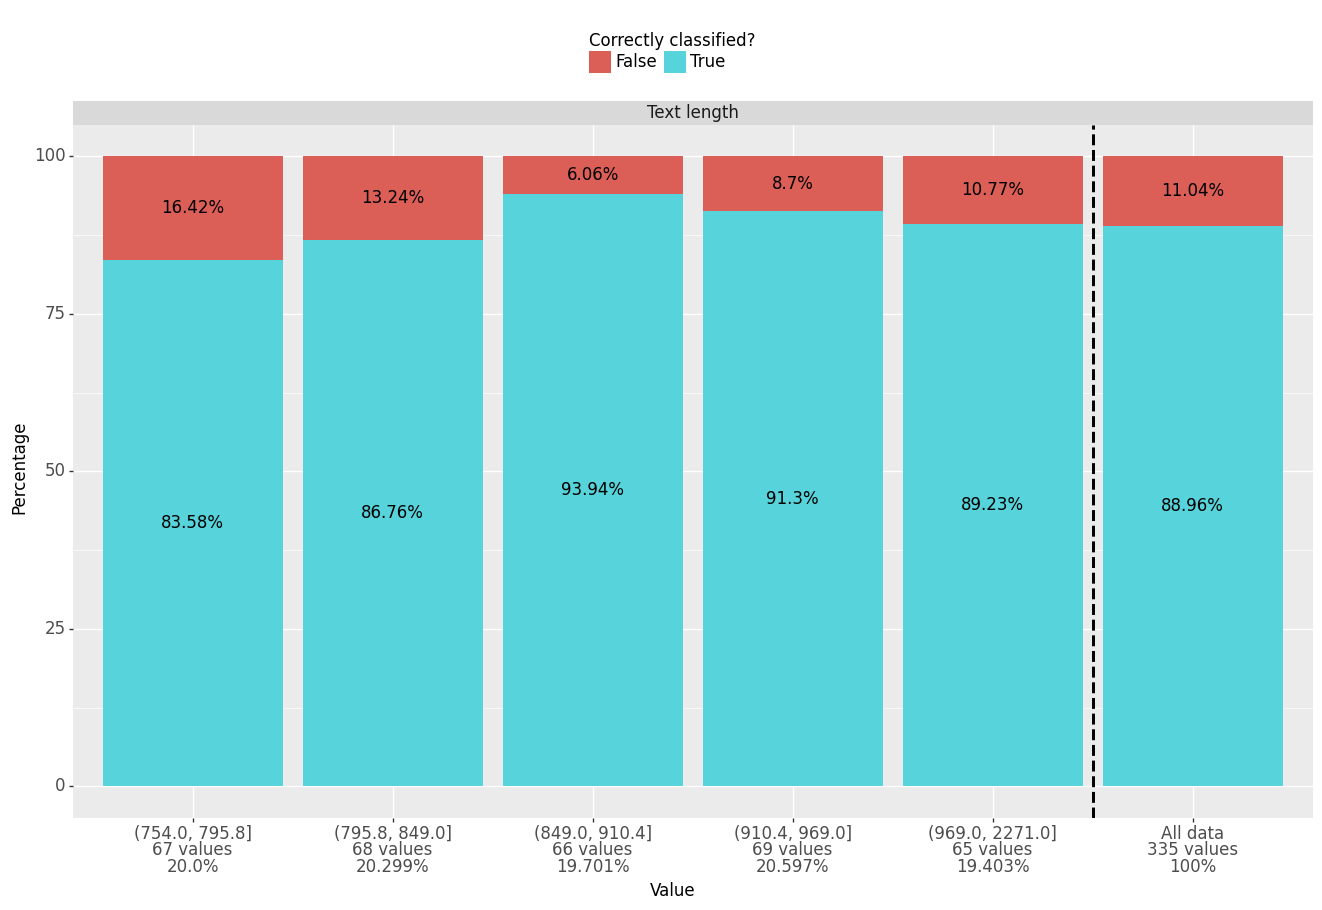

<ggplot: (816212284)>

In [25]:
plot

In [26]:
plot.save(filename = './figures/edp_best_trial_fine_tuned.png', dpi = 300)

## Graph-based predictions

In [27]:
surrogate_df = load_predictions(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True)
surrogate_df['correct'] = surrogate_df['real'] == surrogate_df['prediction']
surrogate_df.drop(columns = ['real', 'prediction'], inplace = True)

### Grouped

In [28]:
grouped_df = pd.concat([
  load_predictions(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'IMDb-top_1000'),
  load_predictions(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'Ohsumed'),
  load_predictions(dataset = 'R8', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'R8'),
  load_predictions(dataset = 'SST-2', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'SST-2'),
])
grouped_df['correct'] = grouped_df['real'] == grouped_df['prediction']
grouped_df.drop(columns = ['real', 'prediction'], inplace = True)

In [29]:
combined_df = pd.merge(grouped_df, text_length_df, on = ['dataset', 'split', 'index']).drop(columns = ['index'])

In [30]:
plot = error_dependence_plot(
  combined_df[(combined_df['dataset'] == 'IMDb-top_1000') & (combined_df['split'] == 'test')].rename(columns = {'length' : 'Text length'})[['Text length', 'correct']],
  target_column = 'correct'
)

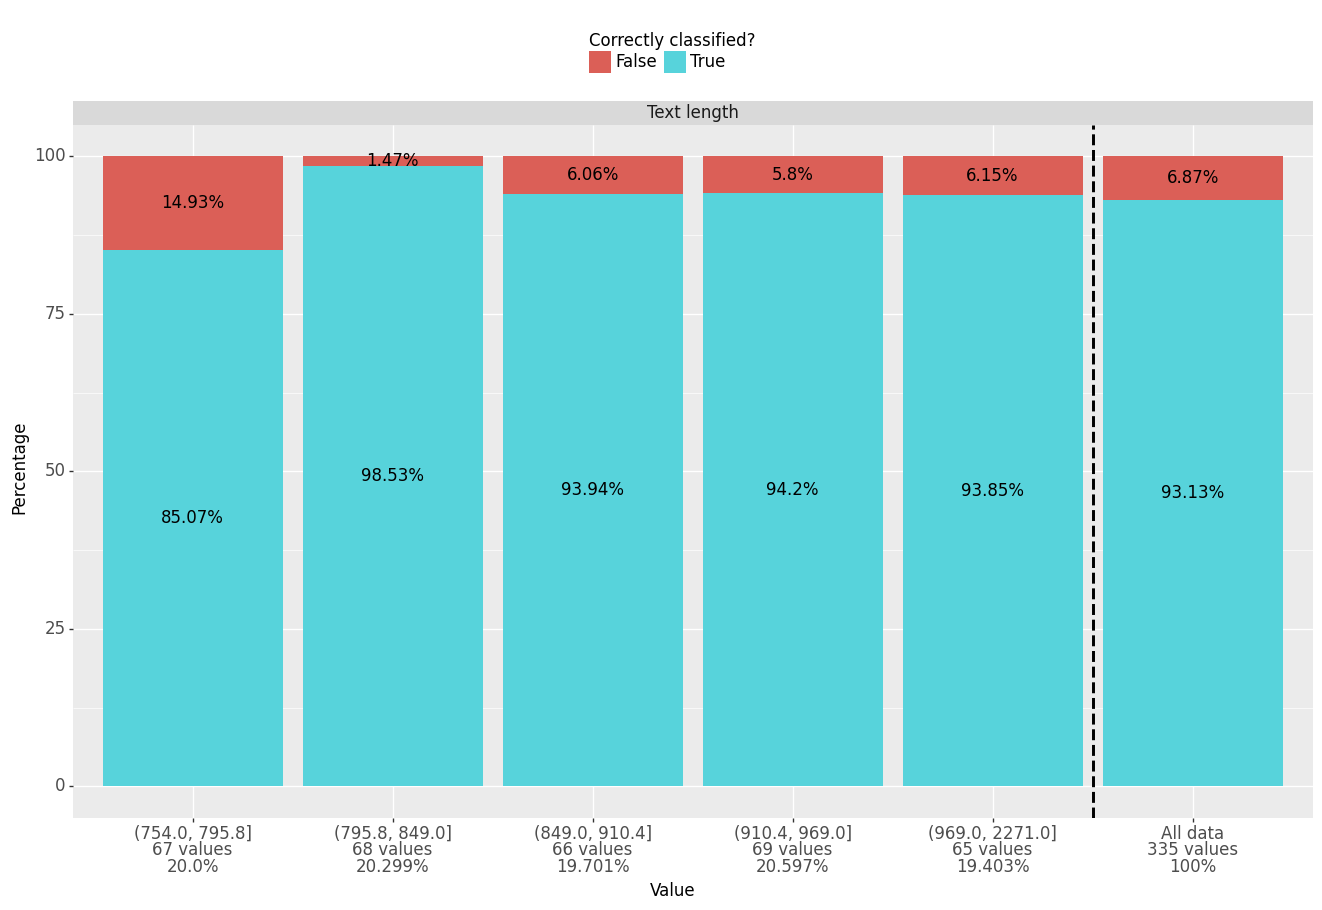

<ggplot: (815080187)>

In [31]:
plot

In [32]:
plot.save(filename = './figures/edp_best_trial_grouped_vs_fine_tuned.png', dpi = 300)

### Surrogate

In [33]:
surrogate_df = pd.concat([
  load_predictions(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'IMDb-top_1000'),
  load_predictions(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'Ohsumed'),
  load_predictions(dataset = 'R8', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'R8'),
  load_predictions(dataset = 'SST-2', gnn = 'GATv2', llm = 'google-bert-bert-base-uncased', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'SST-2'),
])
surrogate_df['correct'] = surrogate_df['real'] == surrogate_df['prediction']
surrogate_df.drop(columns = ['real', 'prediction'], inplace = True)

In [34]:
combined_df = pd.merge(surrogate_df, text_length_df, on = ['dataset', 'split', 'index']).drop(columns = ['index'])

In [35]:
plot = error_dependence_plot(
  combined_df[(combined_df['dataset'] == 'IMDb-top_1000') & (combined_df['split'] == 'test')].rename(columns = {'length' : 'Text length'})[['Text length', 'correct']],
  target_column = 'correct'
)

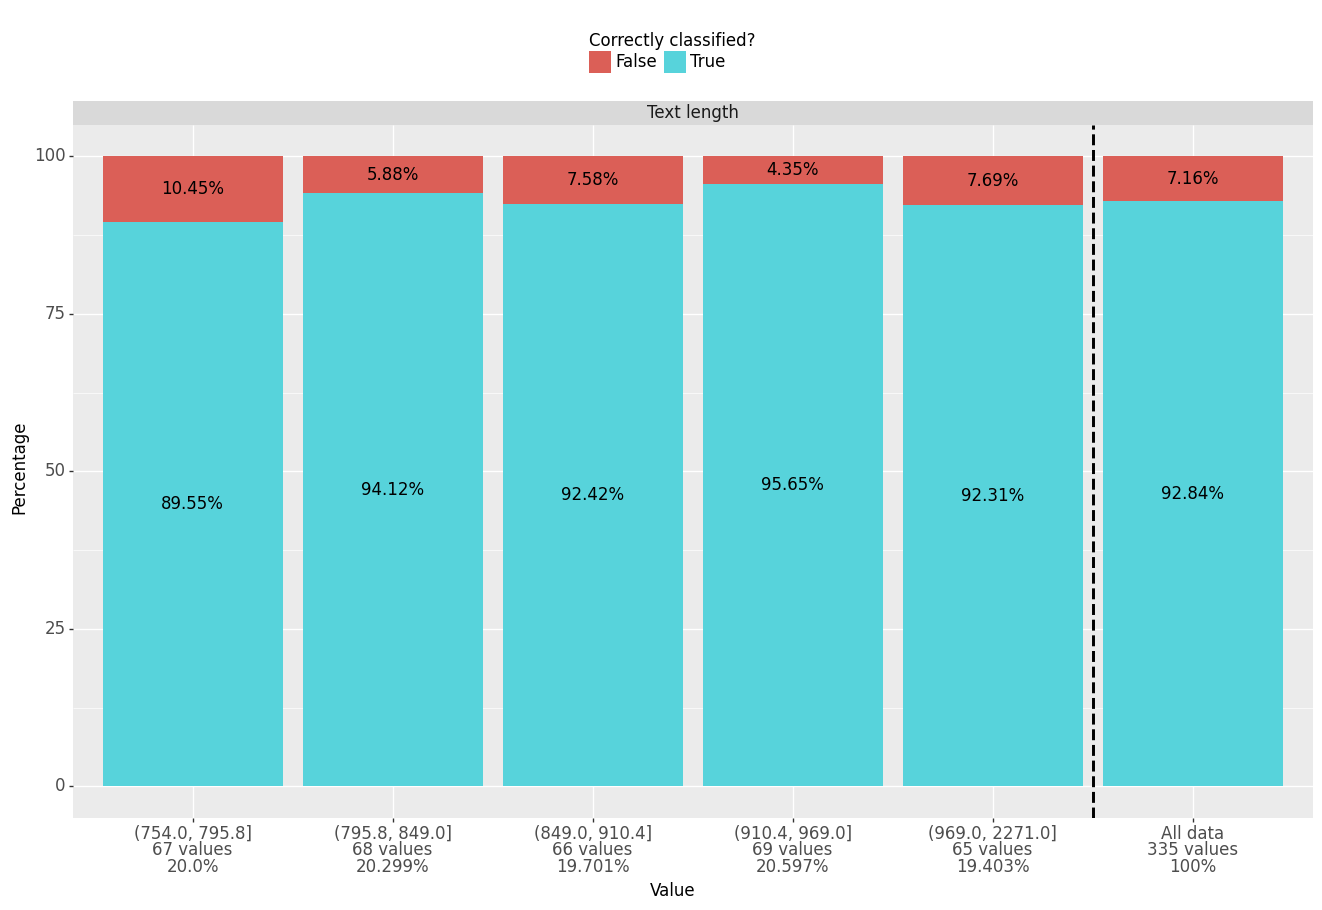

<ggplot: (816806495)>

In [36]:
plot

In [37]:
plot.save(filename = './figures/edp_best_trial_surrogate_vs_fine_tuned.png', dpi = 300)

## Individual file analysis

In [38]:
fine_tuned_vs_grouped = pd.concat([
  fine_tuned_df[(fine_tuned_df['dataset'] == 'IMDb-top_1000') & (fine_tuned_df['split'] == 'test')].assign(method = 'Fine-tuned'),
  grouped_df[(grouped_df['dataset'] == 'IMDb-top_1000') & (grouped_df['split'] == 'test')].assign(method = 'Grouped')
]).query('correct == False')[['index', 'method']].drop_duplicates(subset = ['index'], keep = False)
fine_tuned_vs_grouped

,index,method
23,23,Fine-tuned
33,33,Fine-tuned
37,37,Fine-tuned
52,52,Fine-tuned
53,53,Fine-tuned
68,68,Fine-tuned
73,73,Fine-tuned
88,88,Fine-tuned
89,89,Fine-tuned
93,93,Fine-tuned


In [39]:
fine_tuned_vs_surrogate = pd.concat([
  fine_tuned_df[(fine_tuned_df['dataset'] == 'IMDb-top_1000') & (fine_tuned_df['split'] == 'test')].assign(method = 'Fine-tuned'),
  surrogate_df[(surrogate_df['dataset'] == 'IMDb-top_1000') & (surrogate_df['split'] == 'test')].assign(method = 'Surrogate')
]).query('correct == False')[['index', 'method']].drop_duplicates(subset = ['index'], keep = False)
fine_tuned_vs_surrogate

,index,method
19,19,Fine-tuned
23,23,Fine-tuned
33,33,Fine-tuned
37,37,Fine-tuned
47,47,Fine-tuned
52,52,Fine-tuned
68,68,Fine-tuned
73,73,Fine-tuned
88,88,Fine-tuned
89,89,Fine-tuned


In [40]:
imdb_test_df = pd.read_csv('../../data/with_validation_splits/IMDb-top_1000/test.csv')
# Correct fine-tuned but not method: 5, 86, 261
[print(f'{x}\n') for x in imdb_test_df.iloc[[5, 86, 261]]['text'].values]

The greatest compliments to the other commentator here at IMDb who asked himself why this series didn't "get stuck" in its time to last a lot longer like many other series in the 80s did.<br /><br />It is not true the series would have gotten worse if further continued.<br /><br />I will at the end of this my comment post some thoughts about the other movie realizations, rather: attempts of the Robin Hood legend.<br /><br />First of All, Robert Addie (Gisburne), you are among us all, you live forever.<br /><br />Nothing is as fun as the entire two, if one wants, three seasons of this absolutely unique series. And at the same time absolutely agreeing with the mostly new and revolutionary findings of Terry Jones' history documentations about Egypt, Greece, Rome, Konstantinopel, the Goths and Barbarians, and the middle ages and crusades (...yes, THE Monthy Python-Terry Jones):<br /><br />If you have seen those brilliant and funny Jones-Docs you will better, much better understand all the 

[None, None, None]

In [41]:
# Correct method but not fine-tuned: 23, 111, 270
[print(f'{x}\n') for x in imdb_test_df.iloc[[23, 111, 270]]['text'].values]

... I am left with little choice but to employ it at least once during the course of my review of Respiro. Among other things, what defines pretension is in my opinion a lack of emotional sincerity on the author's part. Respiro seems made with an all too contrived and self-aware intent to be artistic, symbolic, spiritual, provocative, metaphorical... mythical, even. But luckily for all true artists out there, a predisposed formula to achieve artistic beauty and depth doesn't exist. Stunning natural locations (yes, these remote parts of Southern Italy look exotic even to most other Italians), pretty actors and some amusing, gutsy, spontaneous performances by a handful of attractive children won't elevate a substanceless movie beyond a pretty succession of images. Yet this insincere and vain, and ultimately hollow movie aches to be art, succeeding only to a very limited extent, perhaps in some cases by accident. I'll admit that the conceptually pompous ending does have a certain visual p

[None, None, None]

In [42]:
grouped_vs_surrogate = pd.concat([
  grouped_df[(grouped_df['dataset'] == 'IMDb-top_1000') & (grouped_df['split'] == 'test')].assign(method = 'Grouped'),
  surrogate_df[(surrogate_df['dataset'] == 'IMDb-top_1000') & (surrogate_df['split'] == 'test')].assign(method = 'Surrogate')
]).query('correct == False')[['index', 'method']].drop_duplicates(subset = ['index'], keep = False)
grouped_vs_surrogate

,index,method
19,19,Grouped
21,21,Grouped
47,47,Grouped
101,101,Grouped
147,147,Grouped
173,173,Grouped
191,191,Grouped
244,244,Grouped
17,17,Surrogate
53,53,Surrogate


In [43]:
grouped_df[(grouped_df['dataset'] == 'IMDb-top_1000') & (grouped_df['split'] == 'test')].assign(method = 'Grouped')['correct'].value_counts(), surrogate_df[(surrogate_df['dataset'] == 'IMDb-top_1000') & (surrogate_df['split'] == 'test')].assign(method = 'Surrogate')['correct'].value_counts()

(True     312
 False     23
 Name: correct, dtype: int64,
 True     311
 False     24
 Name: correct, dtype: int64)

In [44]:
# Correct grouped but not surrogate: 66, 186, 273
[print(f'{x}\n') for x in imdb_test_df.iloc[[66, 186, 273]]['text'].values]

Special sneak previews are always a good time. No matter what movie it is you are seeing, the theatre will always be packed by people who have been awaiting the film, like free stuff, thought it'd be something to do, or just got lost. Either way, no matter how good or bad the film, the audience alone will make it enjoyable. Now when said movie is a PG-13 pseudo- horror film (can you really delve into horror when the MPAA is on your back censoring everything?) you know there will be chatter, laughing, and breath holding. With The Messengers, the crowd did not disappoint giving numerous outbursts and warnings to the characters on screen. As for the actual movie, I feel sorry for those involved because it really could have been much better had it been paced right and allowed to stretch its legs beyond the scare/fade-to-black/show aftermath progression these films have. In the end we are shown a boring, plodding story with no surprises and few moments of actual suspense.<br /><br />The sto

[None, None, None]

In [45]:
# Correct surrogate but not grouped: 21, 173, 244
[print(f'{x}\n') for x in imdb_test_df.iloc[[21, 173, 244]]['text'].values]

What's there to say about "Pink Flamingos"? It is beyond criticism or even explanation because it doesn't really aspire to be like any other movie you've seen. You will either get it, or you won't, laugh at it or roll your eyes in disgust (or both). John Waters is an odd filmmaker (putting that mildly), mixing both innocent, childlike humor with shockingly offensive moments intended to...well, who knows what his intentions were. It is like a form of assault, albeit a funny one.<br /><br />The thing that makes Waters's humor so infectious and effective is that his characters inhabit a world that can seem both alien and completely familiar to the viewer, like the petty rivalries that form the plot of "Pink Flamingos". Surely everyone has experienced this kind of thing at some point, but almost certainly the matter at stake was not the title of "The Filthiest Person Alive." What makes the movie compelling viewing for me is the way that Waters creates giddy, self-contained environments and

[None, None, None]

# Statistical significance

In [7]:
def get_best_results_for_statistics(datasets, gnns, llm, methods, aggregations, target_metrics):
  results = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for method in methods:
        for aggregation in aggregations:
          if gnn is None and method is None and aggregation is None:
            df = load_performance_metrics_fine_tuned(dataset = dataset, llm = llm)
          else:
            df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation)
          # 'trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'
          df = remove_trials_with_exceptions(df)
          
          df_aggregated = df.groupby(['trial', 'split']).agg({
            'accuracy' : ['mean', 'std'],
            'f1_score' : ['mean', 'std'],
            'precision' : ['mean', 'std'],
            'recall' : ['mean', 'std'],
          }).reset_index()
          df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
          
          best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']
          best_trial = df[df['trial'] == best_trial_number]
          best_trial['target_metric'] = best_trial[target_metric]
          best_trial.drop(columns = ['accuracy', 'f1_score', 'precision', 'recall'], inplace = True)
          best_trial['dataset'] = dataset
          best_trial['gnn'] = gnn
          best_trial['method'] = method
          best_trial['aggregation'] = aggregation
          results.append(best_trial)

  return pd.concat(results, axis = 0)

In [13]:
stats_df = pd.concat([
  get_best_results_for_statistics(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = ['GATv2'],
    llm = 'google-bert-bert-base-uncased',
    methods = ['Grouped', 'Surrogate'],
    aggregations = ['No_Aggregation']
  ),
  get_best_results_for_statistics(
    datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
    target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
    gnns = [None],
    llm = 'google-bert-bert-base-uncased',
    methods = [None],
    aggregations = [None]
  ).assign(gnn = 'N/A', method = 'Fine-tuned', aggregation = 'N/A')
])

In [14]:
stats_df

,trial,random_state,split,target_metric,dataset,gnn,method,aggregation
0,221,42,validation,0.907110,SST-2,GATv2,Grouped,No_Aggregation
1,221,42,test,0.891818,SST-2,GATv2,Grouped,No_Aggregation
2,221,45,validation,0.902523,SST-2,GATv2,Grouped,No_Aggregation
3,221,45,test,0.897309,SST-2,GATv2,Grouped,No_Aggregation
4,221,44,validation,0.902523,SST-2,GATv2,Grouped,No_Aggregation
...,...,...,...,...,...,...,...,...
15,205,46,test,0.779104,IMDb-top_1000,N/A,Fine-tuned,N/A
16,205,41,validation,0.824242,IMDb-top_1000,N/A,Fine-tuned,N/A
17,205,41,test,0.853731,IMDb-top_1000,N/A,Fine-tuned,N/A
18,205,40,validation,0.818182,IMDb-top_1000,N/A,Fine-tuned,N/A


In [17]:
# Based on https://www.geeksforgeeks.org/how-to-conduct-a-paired-samples-t-test-in-python/
for i, split in enumerate(['validation', 'test']):
  print(split)
  split_df = stats_df[(stats_df['split'] == split)].drop(columns = ['trial', 'split', 'gnn', 'aggregation']) \
    .pivot(index = ['dataset', 'random_state'], columns = 'method', values = 'target_metric') \
    .reset_index() \
    .sort_values(by = ['dataset', 'random_state'])
  
  for (x, y) in itertools.combinations(['Fine-tuned', 'Grouped', 'Surrogate'], 2):
    # H0: Mean Grouped and Surrogate scores are equal
    # H1: Mean Grouped and Surrogate scores are not equal
    statistic, p_value = stats.ttest_rel(split_df[x], split_df[y])
    # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
    print(f'{x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

validation
Fine-tuned - Grouped: Statistic: -3.602487725754648 P-value: 0.000880308422253932 Reject H0? True
Fine-tuned - Surrogate: Statistic: -3.155638464937467 P-value: 0.0030826770189306364 Reject H0? True
Grouped - Surrogate: Statistic: 1.6497165524009894 P-value: 0.10703356294417242 Reject H0? False

test
Fine-tuned - Grouped: Statistic: -1.9258606478243572 P-value: 0.061434354740940764 Reject H0? False
Fine-tuned - Surrogate: Statistic: -1.4497353041323648 P-value: 0.15512701334183476 Reject H0? False
Grouped - Surrogate: Statistic: 2.153111406003345 P-value: 0.037553225925305085 Reject H0? True

